# Boston House Prices

In this notebook, we will build a regression model to predict the price of a house in thousands of dollars based on various factors, such as the number of rooms, the crime rate in the area, the number of schools, etc.

# Preparation

In [1]:
# Importing the necessary libraries
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

#from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

import torch
from torch import nn 
from torch import optim
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Setting the style for graphs
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

In [3]:
# Fix a random number generator for reproducibility of the experiment
np.random.seed(42)
torch.manual_seed(42);

# Data reading

The Boston House Prices dataset is a very popular "initial" dataset in the Machine Learning environment. Download, unpack and look at the data table

In [4]:
df = pd.read_csv('boston.csv')
df.head()

,rownames,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
y = df['medv']
X = df[['crim', 'zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','black','lstat']]

In [6]:
# Data example
X.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [7]:
y[:5]

0    24.0
1    21.6
2    34.7
3    33.4
4    36.2
Name: medv, dtype: float64

In [8]:
# Statistics on data. It is useful to look at them to understand what signs we have in general
X.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


It is important to note here that there are signs of a very different scale in the dataset. Some signs, for example CHAS, have values from 0 to 1, and some, for example ZN, from 0 to 100.

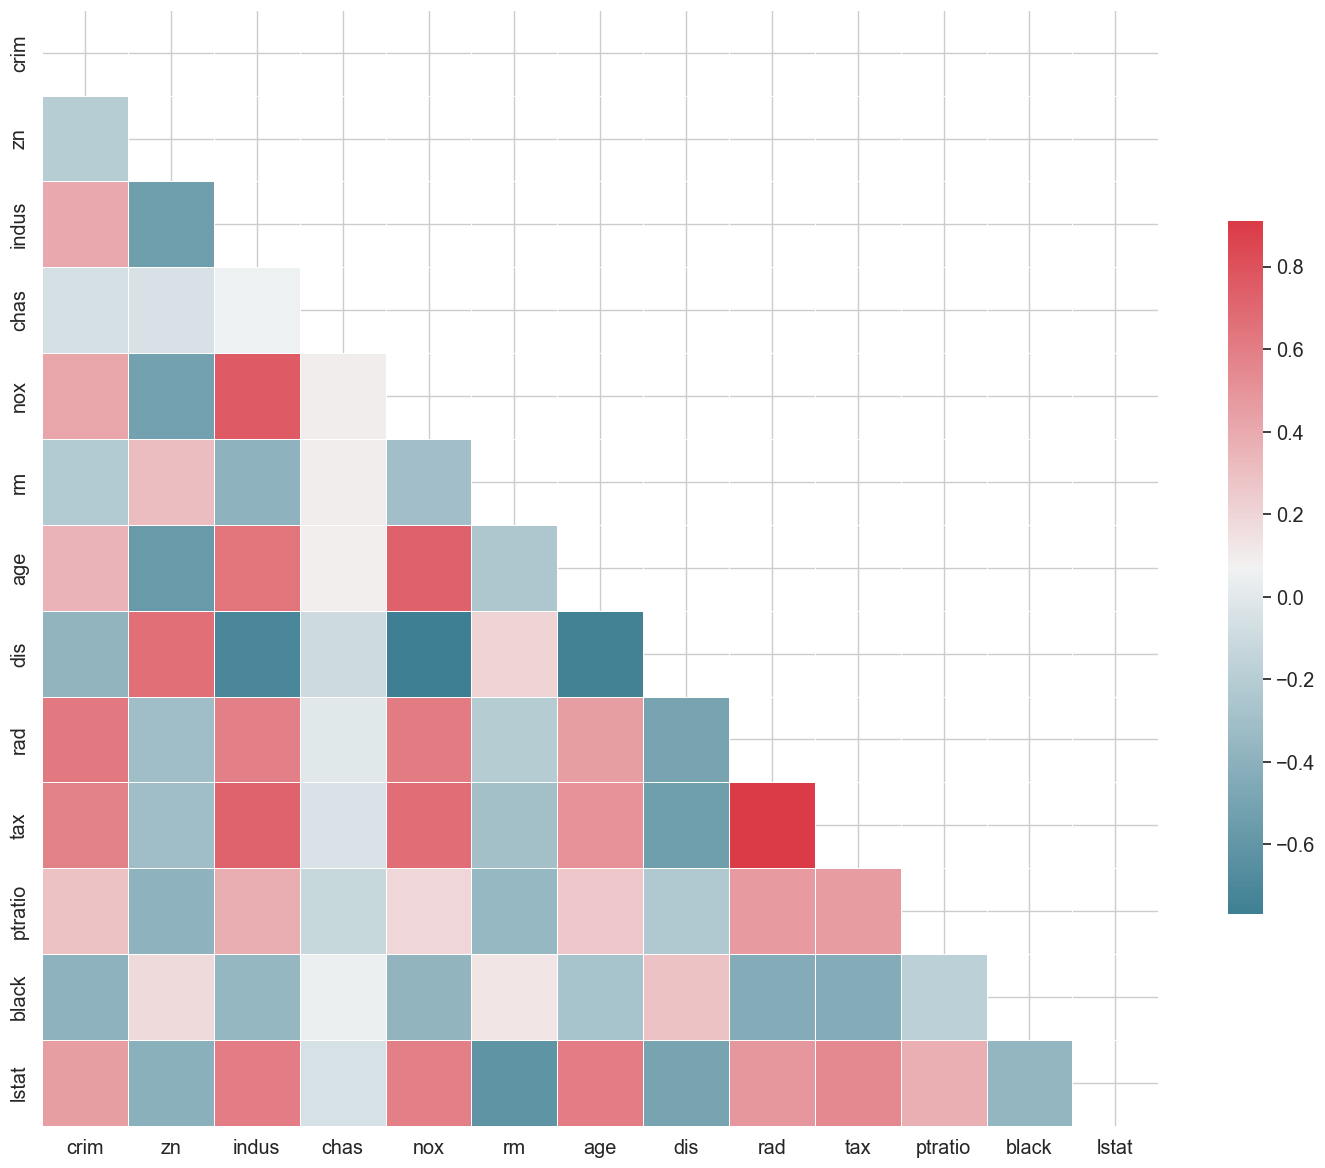

In [9]:
# Let's look at the matrix of correlations between the features
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 18))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,
            square=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

# Data preprocessing

## Splitting

Let's split our data into training and validation samples in the proportion of $\frac{4}{1}$

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

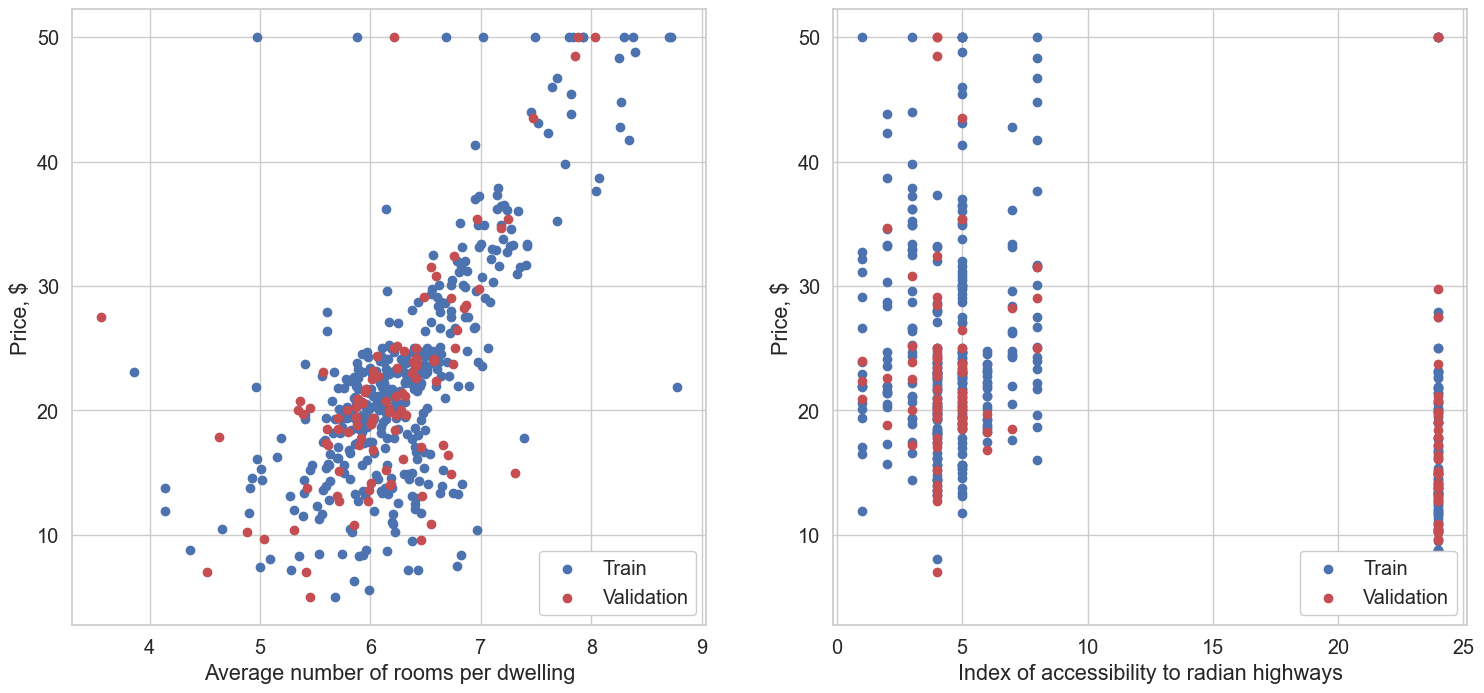

In [11]:
# There are quite a lot of signs in the dataset, so let's visualize just some of them
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.rm, y_train, label='Train')
plt.scatter(X_val.rm, y_val, c='r', label='Validation')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Price, $')
plt.legend(loc='lower right', frameon=True)
plt.subplot(122)
plt.scatter(X_train.rad, y_train, label='Train')
plt.scatter(X_val.rad, y_val, c='r', label='Validation')
plt.xlabel('Index of accessibility to radian highways')
plt.ylabel('Price, $')
plt.legend(loc='lower right');

## Scale

Let's normalize each attribute to the range $(0; 1)$. This is a purely technical trick that does not change the essence of the data, but greatly simplifies the training for optimization algorithms.

In [12]:
scaler = MinMaxScaler()

Note that normalization constants are calculated only on the basis of training data. This is done because in reality, the data on which the model will be applied will not be available during training. And in our case, the validation sample just simulates such data, so it would be wrong to take it into account in the calculation of constants.

In [13]:
X_train_scaled = scaler.fit_transform(X_train)

Let's apply the same constants from the training sample now to the validation data. Note that in this case, some data may already go beyond 0 to 1, but it will still be of a similar scale.

In [14]:
X_val_scaled = scaler.transform(X_val)

## Creating tensors

Pytorch requires its own type of vectors, which is called tensor and is slightly different from the format in numpy

In [15]:
X_train_tensor = torch.tensor(np.array(X_train_scaled), dtype=torch.float)
X_val_tensor = torch.tensor(np.array(X_val_scaled), dtype=torch.float)

y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float)
y_val_tensor = torch.tensor(y_val[:, None], dtype=torch.float)

/var/folders/qq/gt96f0sx7nn6wsr9d8n13r2w0000gn/T/ipykernel_59443/563204829.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float)
/var/folders/qq/gt96f0sx7nn6wsr9d8n13r2w0000gn/T/ipykernel_59443/563204829.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_val_tensor = torch.tensor(y_val[:, None], dtype=torch.float)


In [16]:
X_val_tensor[12]

tensor([0.5141, 0.0000, 0.6430, 0.0000, 0.6337, 0.1334, 1.0000, 0.0481, 1.0000,
        0.9141, 0.8085, 0.2218, 0.9727])

We will also define the basic constants from the data in order to use them in the future

In [17]:
n_data, n_features = X_train_tensor.shape

In [18]:
n_data

404

In [19]:
n_features

13

# Quality assessment

Будем оценивать нашу модель по двум метрикам:
* MSE (Mean Squared Error)
$$
L = (y - \hat{y})^2
$$
* * MARE (Mean Absolute Percentage Error)
$$
L = \frac{/y-\hat{y}|}{y}
$$

MSE is one of the most popular metrics and it is implemented in all machine learning libraries. MAPE is less popular and therefore we will have to write it by hand.

In [20]:
def mape_loss(input, target):
    return torch.mean(F.l1_loss(input, target, reduction='none') / target)

Now let's define the error function, according to which we will train the model. In our case it is MSE

In [21]:
loss_func = F.mse_loss

And we will also set a set of metrics that we want to track

In [22]:
metrics_func = [loss_func, mape_loss]
metrics_name = ['MSE', 'MAPE']

Let's define a function for evaluating the quality of one model on a given dataset by given metrics

In [23]:
def evaluate(model, metrics_func, X, y):
    metrics_value = []
    with torch.no_grad():
        preds = model(X)
        for metric_func in metrics_func:
            metric_value = metric_func(torch.FloatTensor(preds).flatten(), torch.FloatTensor(y).flatten())
            metrics_value.append(metric_value)
    return metrics_value

A utility to evaluate the quality on many models at once and immediately on both training and validation data in accordance with all metrics

In [24]:
def print_metrics(models, metric_func, train_data, val_data, metrics_name, models_name):
    results = np.zeros(2 * len(models), len(metrics_func))
    data_name = []
    for m in models_name:
        data_name.extend([m + ' Train', m + ' Validation'])
    for m_num, model in enumerate(models):
        for row, sample in enumerate([train_data, val_data]):
            results[row + m_num * 2] = evaluate(model, metrics_func, sample[0], sample[1])
    results = pd.DataFrame(results, columns=metrics_name, index=data_name)
    return results

A utility to visualize how well we predict

In [25]:
def draw_predictions(y_true, y_pred, model_name=None):
    if model_name is None:
        model_name = 'Model'
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlim([5, 50])
    plt.ylim([5, 50])
    sns.regplot(x=y_true, y=y_pred, robust=True,
                label=model_name,
                scatter_kws={'zorder': 10}, line_kws={'zorder': 15})
    ax.set_xlabel('Ground truth')
    ax.set_ylabel('Predictions')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]), # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]), # max of both axes
    ]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=5, label='Perfect')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.legend()

# Models

## Baseline: Sklean Linear Regression

In [26]:
%%time

model_lr_sklearn = LinearRegression()
model_lr_sklearn.fit(X_train_scaled, y_train)

CPU times: user 2.75 ms, sys: 5.77 ms, total: 8.52 ms
Wall time: 11.7 ms


LinearRegression()

In [27]:
print_metrics(models=[model_lr_sklearn.predict],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR"])

TypeError: print_metrics() got an unexpected keyword argument 'metrics_func'

Let's draw predictions

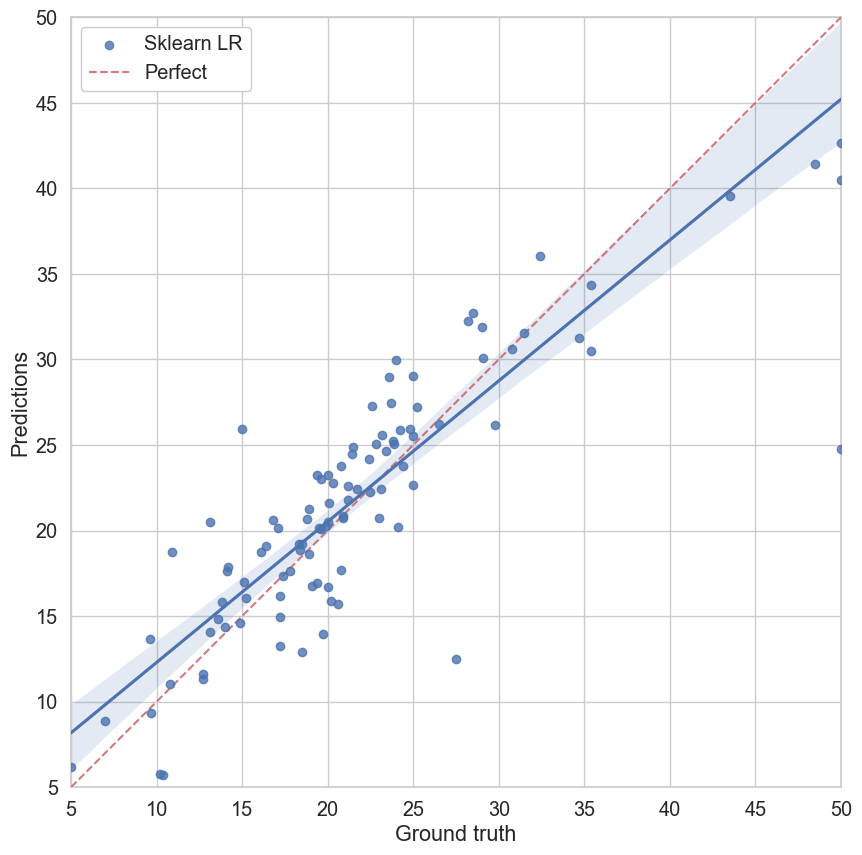

In [28]:
draw_predictions(
    y_true=y_val,
    y_pred=model_lr_sklearn.predict(X_val_scaled),
    model_name='Sklearn LR'
)

## PyTorch

### Linear Regrassion

The "Linear regression" model can be considered as a simple neural network without hidden layers and without activation functions

The number of signs in the Boston House Prices dataset is 13. Therefore, the input layer has 13 neurons. We want to predict only one value - the price of the apartment. Therefore, the output layer has only one neuron.

In [29]:
model_lr = nn.Sequential(
    nn.Linear(in_features=n_features, out_features=1),
)

Linear regression is one of the few models for which optimal weights can be found accurately (using a specific formula). Exactly this was done in the previous section using Sklearn.

Now we want to train a neural network, so we will use the simplest gradient method of step-by-step optimization - Batch Gradient Descent.

In [30]:
opt_lr = optim.SGD(params=model_lr.parameters(), lr=0.01)
batch_size_lr = 16

Training model

In [31]:
%%time

epochs_lr = 1000
history_lr_train = []
history_lr_val = []

for epoch in tqdm(range(epochs_lr)):
    for i in range((n_data - 1) // batch_size_lr + 1):

        # Data batch forming
        start_i = i * batch_size_lr
        end_i = start_i + batch_size_lr
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]

        # Forward pass: make predictions
        pred = model_lr(Xb)
        # Forward pass: calculate loss
        loss = loss_func(pred, yb)

        # backward pass: calculate gradients
        loss.backward()

        # Updating the scales
        opt_lr.step()
        opt_lr.zero_grad()

    history_lr_train.append(evaluate(model_lr, metrics_func, X_train_tensor, y_train_tensor))
    history_lr_val.append(evaluate(model_lr, metrics_func, X_val_tensor, y_val_tensor))

history_lr_train = np.array(history_lr_train)
history_lr_val = np.array(history_lr_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 1.93 s, sys: 53.2 ms, total: 1.98 s
Wall time: 2.03 s


Let's draw how the error function changed in the course of training

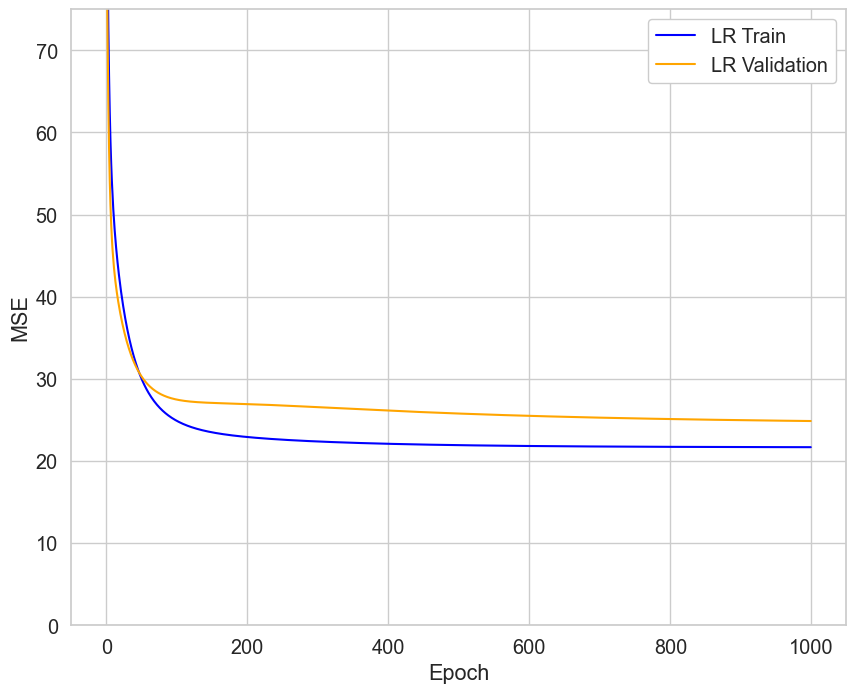

In [32]:
plt.figure(figsize=(10, 8))
plt.plot(history_lr_train[:, 0], label='LR Train', color='blue')
plt.plot(history_lr_val[:, 0], label='LR Validation', color='orange')
plt.legend(frameon=True)
plt.ylim([0, 75])
plt.ylabel('MSE')
plt.xlabel('Epoch');

In [33]:
print_metrics(models=[model_lr_sklearn.predict, model_lr],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR", "LR"])

TypeError: print_metrics() got an unexpected keyword argument 'metrics_func'

Prediction example

In [34]:
X_val.tail(1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
75,0.09512,0.0,12.83,0,0.437,6.286,45.0,4.5026,5,398,18.7,383.23,8.94


In [35]:
y_val.tail(1)

75    21.4
Name: medv, dtype: float64

In [36]:
with torch.no_grad():
    print(model_lr(X_val_tensor[-1:]))

tensor([[24.4621]])


In [37]:
X_val_tensor[12]

tensor([0.5141, 0.0000, 0.6430, 0.0000, 0.6337, 0.1334, 1.0000, 0.0481, 1.0000,
        0.9141, 0.8085, 0.2218, 0.9727])

In [38]:
x_t = torch.Tensor([0.5141, 0.0000, 0.6430, 0.0000, 0.6337, 0.1334, 1.0000, 0.0481, 1.0000,
        0.9141, 0.8085, 0.2218, 0.9727])
with torch.no_grad():
    print(model_lr(x_t))

tensor([-6.0432])


Draw predictions

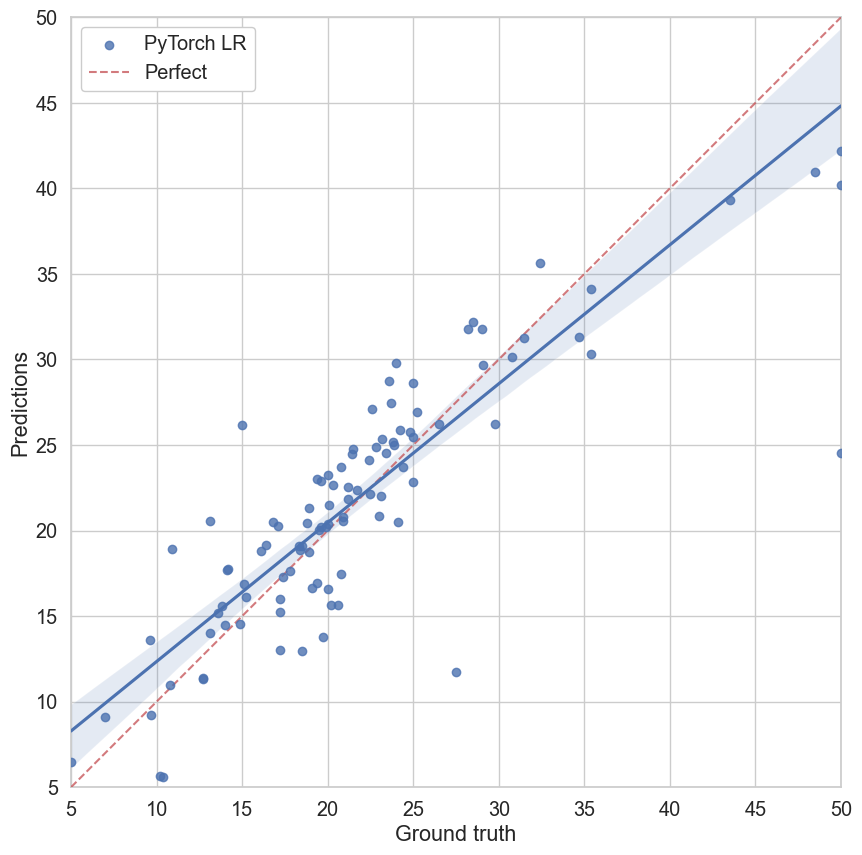

In [39]:
with torch.no_grad():
    draw_predictions(
        y_true=y_val,
        y_pred=np.array(model_lr(X_val_tensor)).flatten(),
        model_name='PyTorch LR'
    )

### MLP with 3 hidden layers

Now let's define a more complex model with 3 hidden layers and a ReLU activation function.

![relu image](https://analyticsindiamag.com/wp-content/uploads/2018/01/relu-activation-function-1.png)

In [40]:
model_mlp_3 = nn.Sequential (
    nn.Linear(in_features=n_features, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=1)
)

The setting for learning is almost the same except for the learning rate. Now we will make it smaller to take into account the more complex space of the scales, which is easier to pass with smaller steps.

In [41]:
opt_mlp_3 = optim.SGD(params=model_mlp_3.parameters(), lr=0.0001)
batch_size_mlp_3 = 16

Training model

In [42]:
%%time

epochs_mlp_3 = 1000
history_mlp_3_train = []
history_mlp_3_val = []

for epoch in tqdm(range(epochs_mlp_3)):
    for i in range((n_data - 1) // batch_size_mlp_3 + 1):
        start_i = i * batch_size_mlp_3
        end_i = start_i + batch_size_mlp_3
        Xb = X_train_tensor[start_i:end_i]
        yb = y_train_tensor[start_i:end_i]
        pred = model_mlp_3(Xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt_mlp_3.step()
        opt_mlp_3.zero_grad()

    history_mlp_3_train.append(evaluate(model_mlp_3, metrics_func, X_train_tensor, y_train_tensor))
    history_mlp_3_val.append(evaluate(model_mlp_3, metrics_func, X_val_tensor, y_val_tensor))

history_mlp_3_train = np.array(history_mlp_3_train)
history_mlp_3_val = np.array(history_mlp_3_val)

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 5.03 s, sys: 69 ms, total: 5.1 s
Wall time: 5.11 s


Let's draw how the error function changed during training and compare it with the previous model (PyTorch Linear Regression)

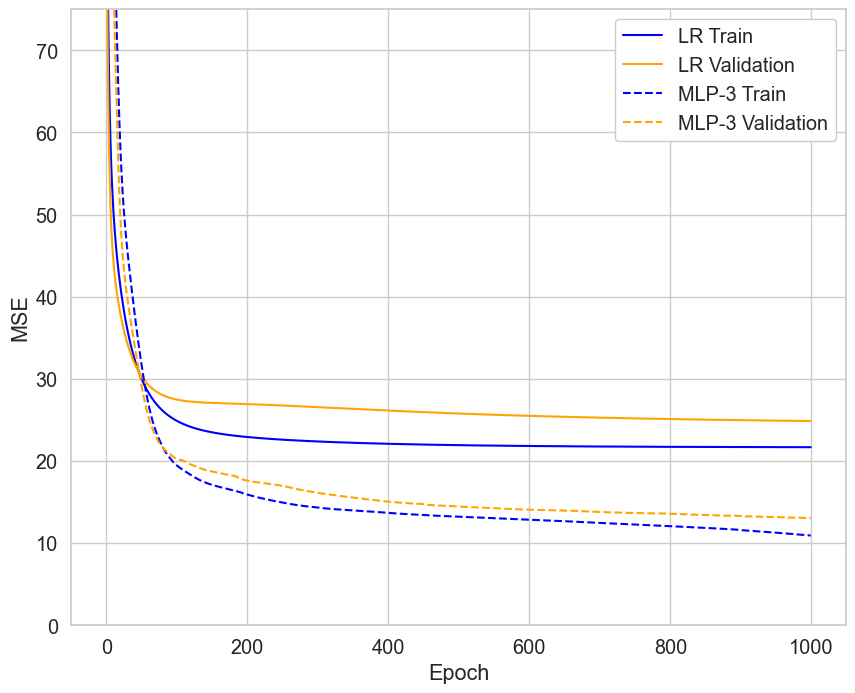

In [43]:
plt.figure(figsize=(10, 8))
plt.plot(history_lr_train[:, 0], label='LR Train', color='blue')
plt.plot(history_lr_val[:, 0], label='LR Validation', color='orange')
plt.plot(history_mlp_3_train[:, 0], label='MLP-3 Train', color='blue', linestyle='--')
plt.plot(history_mlp_3_val[:, 0], label='MLP-3 Validation', color='orange', linestyle='--')
plt.legend(frameon=True)
plt.ylim([0, 75])
plt.ylabel('MSE')
plt.xlabel('Epoch');

In [44]:
print_metrics(models=[model_lr_sklearn.predict, model_lr, model_mlp_3],
              metrics_func=metrics_func,
              train_data=(X_train_tensor, y_train_tensor),
              val_data=(X_val_tensor, y_val_tensor),
              metrics_name=["MSE", "MAPE"],
              models_name=["Sk LR", "LR", "MLP-3"])

TypeError: print_metrics() got an unexpected keyword argument 'metrics_func'

Prediction example

In [45]:
X_val.tail(1)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
75,0.09512,0.0,12.83,0,0.437,6.286,45.0,4.5026,5,398,18.7,383.23,8.94


In [46]:
y_val.tail(1)

75    21.4
Name: medv, dtype: float64

In [47]:
with torch.no_grad():
    print(model_mlp_3(X_val_tensor[-1:]))

tensor([[22.0545]])


Draw predictions

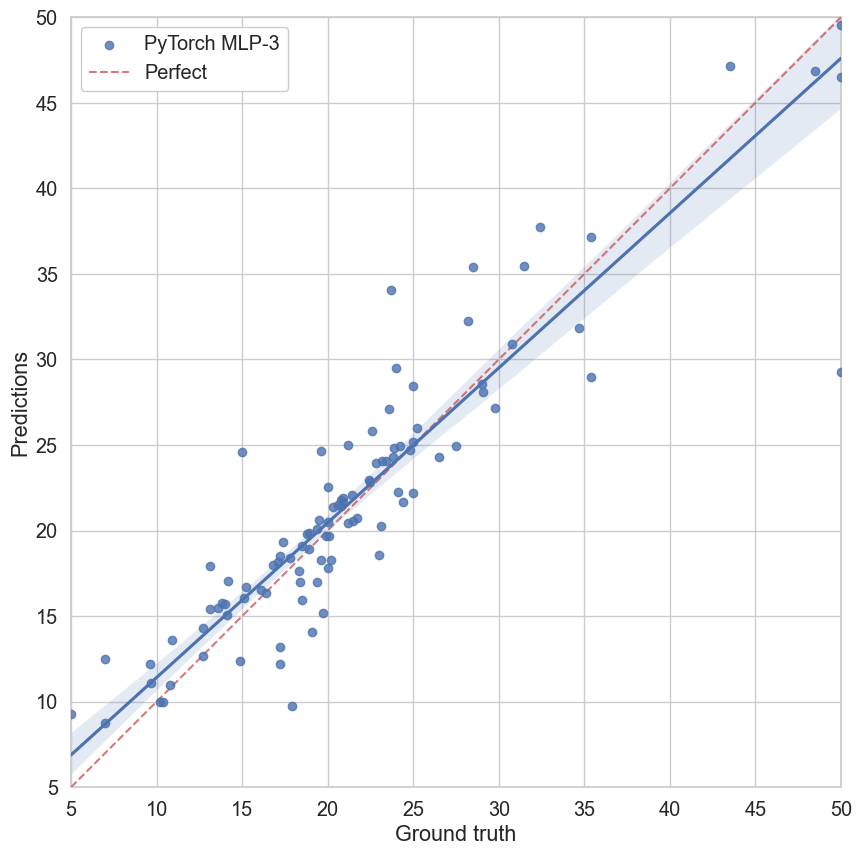

In [48]:
with torch.no_grad():
    draw_predictions(
        y_true=y_val,
        y_pred=np.array(model_mlp_3(X_val_tensor)).flatten(),
        model_name='PyTorch MLP-3',
    )

Save model for next using

In [49]:
torch.save(model_mlp_3, 'mlp3.pth')